In [19]:
import os
import random
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, TimeDistributed, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.callbacks import EarlyStopping
import tensorflow as tf

import dues_utilities as utils
import matplotlib.pyplot as plt

import importlib
importlib.reload(utils)

<module 'dues_utilities' from 'C:\\Users\\benchoi\\Projects\\dues\\ml\\dues_utilities.py'>

In [20]:
# Number of timesteps before 't' model uses in each prediction step
timesteps = 24

# Additional Parameters
add_context = True # whether all sim or just relevant sim data is given at each prediciton step
num_targets = 29 # number of buildings
verbose = 0 # controls verbosity of output during training
N = 5 # number of times to repreat each experiment (and average results across)

# Define queries for each fold
folds = utils.get_folds(3)

# Callback Functions
callbacks = []
callbacks.append(EarlyStopping(patience=2))

In [21]:
# Read data formatted by R scripts

PATH_ENERGY_BASELINE = "../data/all/building_energy_retrofit_baseline.csv"
PATH_ENERGY_ACTUAL_STATIONARY = "../data/building_energy_actual_stationary.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_retrofit_baseline = pd.read_csv(PATH_ENERGY_BASELINE, dtype=energy_dtype)
energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL_STATIONARY, dtype=energy_dtype)

# Combined simulation and observed data into properly formatted dataframe
energy = utils.get_energy_df(
        energy_retrofit_baseline, 
        energy_actual, 
        one_hot=False, 
        temporal_scale='hour', 
        spatial_scale='building',
        add_context=add_context
    )

Retrieving DUE-S Energy Data...


## Supervised Experiments

In [ ]:
# Query for train, val, test split
train_folds, val_folds, test_folds = utils.make_supervised_folds(folds, energy, timesteps, None)
n_features = train_folds[0][0].shape[-1]

### Linear Regression

In [ ]:
lr_model = LinearRegression()

metrics = utils.walk_forward_cv(lr_model, train_folds, val_folds, test_folds, simple=True)

utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 189.93959824244183
# MSE: 9141.97998046875
# CV(RMSE): 55.47295276815662
# MBE: -2.020330448945363

# Overall Test:
# MAPE: 189.31085268656415
# MSE: 8597.76416015625
# CV(RMSE): 54.17478953866275
# MBE: -1.8855419158935547

### KNN

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=1)

metrics = utils.walk_forward_cv(knn_model, train_folds, val_folds, test_folds, simple=True)

utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 36.308494955301285
# MSE: 7894.553466796875
# CV(RMSE): 50.844112055883855
# MBE: 15.018418371677399

# Overall Test:
# MAPE: 35.82461327314377
# MSE: 5369.8382568359375
# CV(RMSE): 42.84330763067136
# MBE: 4.418466746807098

### ANN

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(8, activation='relu', input_shape = [n_features]))
ann_model.add(Dense(1))

metrics = utils.repeat_experiment(
        ann_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="ANN"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 38.00202697515488
# MSE: 43097.4432800293
# CV(RMSE): 117.60132177260635
# MBE: -69.48708001375198

# Overall Test:
# MAPE: 40.03982916474342
# MSE: 42431.93391723634
# CV(RMSE): 117.8805092994159
# MBE: -70.02141468524933

#### Reshaping for Models with 3D Input



In [ ]:
for idx, fold in enumerate(train_folds):
    train_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(train_folds[idx][0][:, :-num_targets], timesteps, df_name="Train"),
                np.repeat(train_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        train_folds[idx][1]
    )
    val_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(val_folds[idx][0][:, :-num_targets], timesteps, df_name="Val"),
                np.repeat(val_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        val_folds[idx][1]
    )
    test_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(test_folds[idx][0][:, :-num_targets], timesteps, df_name="Test"),
                np.repeat(test_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        test_folds[idx][1]
    )

n_features = train_folds[0][0].shape[-1]

### Vanilla LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(8, input_shape = (timesteps, n_features)))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))

metrics = utils.repeat_experiment(
        lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Vanilla LSTM"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 50.77106049284339
# MSE: 9434.811126708984
# CV(RMSE): 54.157817864135325
# MBE: -14.903981592878699

# Overall Test:
# MAPE: 42.56542481482029
# MSE: 8869.950701904296
# CV(RMSE): 54.161317168255835
# MBE: -20.77920241802931

### CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(8, kernel_size=2, input_shape = (timesteps, n_features)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))

metrics = utils.repeat_experiment(
        cnn_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="CNN"
    )
utils.print_overall_metrics(metrics)

# Overall Validation:
# MAPE: 39.318471290171146
# MSE: 8778.81907043457
# CV(RMSE): 54.12282267014075
# MBE: -17.353715103864673

# Overall Test:
# MAPE: 41.622185446321964
# MSE: 8367.039208984375
# CV(RMSE): 53.45222762279509
# MBE: -20.648522400856017

## Sequence Experiments

In [22]:
energy = utils.get_energy_df(
        energy_retrofit_baseline, 
        energy_actual, 
        one_hot=False, 
        temporal_scale='hour', 
        spatial_scale='building', 
        add_context=add_context
    )

train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, scalers=None)

n_features = train_folds[0][0].shape[-1]
    
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.equalize_timesteps(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 58) (5220, 24, 1)
Val: (5307, 24, 58) (5307, 24, 1)
Test: (5220, 24, 58) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 58) (10556, 24, 1)
Val: (5220, 24, 58) (5220, 24, 1)
Test: (5307, 24, 58) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 58) (15805, 24, 1)
Val: (5307, 24, 58) (5307, 24, 1)
Test: (10556, 24, 58) (10556, 24, 1)


### Vanilla LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 24, 64)            31488     
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


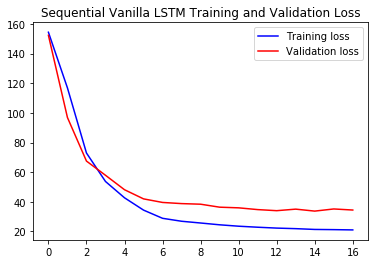


Fold #2


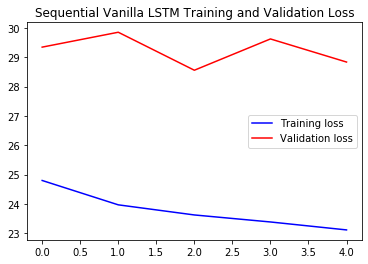


Fold #3


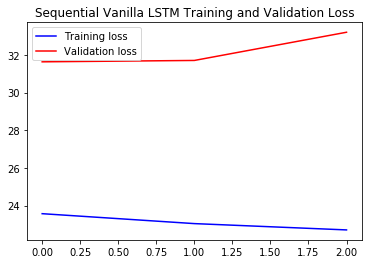

-----Experiment #2-----

Fold #1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 24, 64)            31488     
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


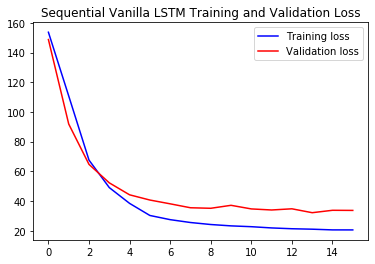


Fold #2


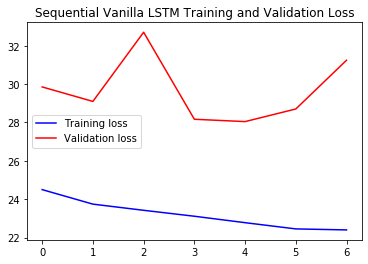


Fold #3


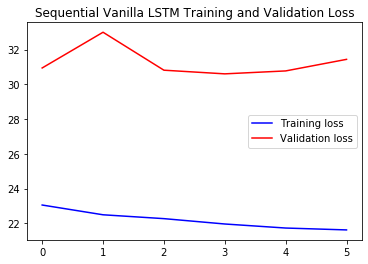

-----Experiment #3-----

Fold #1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 24, 64)            31488     
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


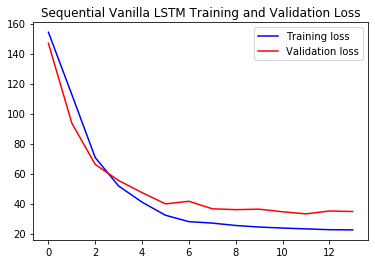


Fold #2


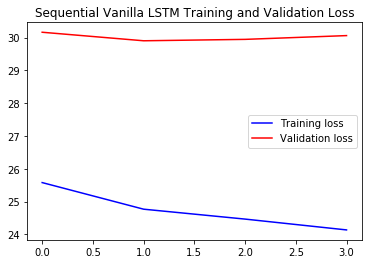


Fold #3


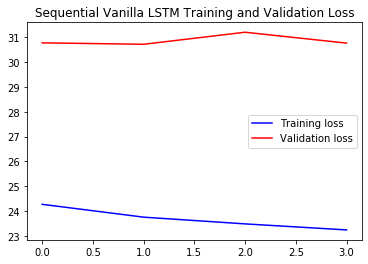

-----Experiment #4-----

Fold #1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 24, 64)            31488     
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Vanilla LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

In [ ]:
energy = utils.get_energy_df(
        energy_retrofit_baseline, 
        energy_actual, 
        one_hot=False, 
        temporal_scale='hour', 
        spatial_scale='building', 
        add_context=False
    )

train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, scalers=None)

n_features = train_folds[0][0].shape[-1]
    
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.equalize_timesteps(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

In [ ]:
# No Context Experiments

context_model = lstm_model

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Vanilla LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

### Seq2Seq LSTM

In [ ]:
lstm_autoencoder_model = Sequential()
lstm_autoencoder_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=False))
lstm_autoencoder_model.add(RepeatVector(timesteps))
lstm_autoencoder_model.add(LSTM(64, return_sequences=True))
lstm_autoencoder_model.add(TimeDistributed(Dense(32, activation='relu')))
lstm_autoencoder_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        lstm_autoencoder_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential Seq2Seq LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

### CNN-LSTM

In [ ]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, activation='relu', kernel_size=2, input_shape=(timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(RepeatVector(timesteps))
cnn_lstm_model.add(LSTM(64, return_sequences=True))
cnn_lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
cnn_lstm_model.add(TimeDistributed(Dense(1)))

metrics = utils.repeat_experiment(
        cnn_lstm_model, N,
        train_folds, val_folds, test_folds, 
        callbacks, verbose, 
        model_name="Sequential CNN-LSTM",
        val_agg_df=val_agg_ref, test_agg_df=test_agg_ref
    )

print(metrics[0])
print(metrics[1])

## Retrofit Experiments

In [ ]:
model = lstm_model

PATH_RETROFIT_ROOT = "../data/all/"
PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_all_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_block_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_old_mae.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_all_mae_no_context.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_block_mae_no_context.csv"
# PATH_RETROFIT_OUTPUT = "../data/output_retrofit/all_months/output_retrofit_old_mae_no_context.csv"

In [ ]:
PATH_ENERGY_FULL = PATH_RETROFIT_ROOT + "building_energy_retrofit_full.csv"
PATH_ENERGY_LIGHT = PATH_RETROFIT_ROOT + "building_energy_retrofit_light.csv"
PATH_ENERGY_WINDOW = PATH_RETROFIT_ROOT + "building_energy_retrofit_window.csv"

energy_retrofit_full = pd.read_csv(PATH_ENERGY_FULL, dtype=energy_dtype)
energy_retrofit_light = pd.read_csv(PATH_ENERGY_LIGHT, dtype=energy_dtype)
energy_retrofit_window = pd.read_csv(PATH_ENERGY_WINDOW, dtype=energy_dtype)

energy_retrofits = utils.equalize_timesteps(energy, folds[-1][-1], timesteps, one_hot=False)
energy_retrofits = energy_retrofits.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual'])
energy_retrofits['kwh_actual'] = energy_retrofits['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

scalers = utils.make_seq_folds(folds, energy, timesteps, scalers=None, get_scalers=True)

energy_full = utils.get_energy_df(energy_retrofit_full, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
full_train_folds, full_val_folds, full_test_folds = utils.make_seq_folds(folds, energy_full, timesteps, scalers)

energy_light = utils.get_energy_df(energy_retrofit_light, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
light_train_folds, light_val_folds, light_test_folds = utils.make_seq_folds(folds, energy_light, timesteps, scalers)

energy_window = utils.get_energy_df(energy_retrofit_window, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building', add_context=add_context)
window_train_folds, window_val_folds, window_test_folds = utils.make_seq_folds(folds, energy_window, timesteps, scalers)

energy_retrofits['kwh_baseline'] = model.predict(test_folds[-1][0]).ravel()
energy_retrofits['kwh_full'] = model.predict(full_test_folds[-1][0]).ravel()
energy_retrofits['kwh_light'] = model.predict(light_test_folds[-1][0]).ravel()
energy_retrofits['kwh_window'] = model.predict(window_test_folds[-1][0]).ravel()

In [ ]:
# energy_retrofits.to_csv(PATH_RETROFIT_OUTPUT, index=False)

In [ ]:
# Todos:

# [X] Investigate exploding gradients, using clip values for gradient clipping
# [X] Visualize per building error distribution
# [X] Implement additional benchmarks (e.g. SVR?)
# [X] Multiple temporal and spatial scale analysis
# [X] See what happens with retrofits
# [ ] Experiment with subsetting to optimize for cumulative urban-scale reductions in energy/CO2 consumption
# [ ] Investigate domain transfer techniques
# [ ] Investigate visualization strategies for LSTM and Conv Layers